

# Import Libraries



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import itertools

# Load Data

In [5]:
# Load Data

files = glob.glob("/content/drive/MyDrive/A03_data/training_data/order_data/*")
data = [pd.read_csv(f, header=None) for f in files]
data = pd.concat(data, ignore_index=True)
data = data.iloc[:, 0].str.split("\t", expand=True)
data.columns = [
    "order_id",
    "driver_id",
    "passenger_id",
    "start_region_hash",
    "dest_region_hash",
    "Price",
    "Time",
]
# Convert 'Time' to datetime
datetime_converted = pd.to_datetime(data['Time'])

# Extract day from 'Time'
data['day'] = datetime_converted.dt.day

region = pd.read_csv("/content/drive/MyDrive/A03_data/training_data/cluster_map/cluster_map", header=None)
region = region.iloc[:, 0].str.split("\t", expand=True)
region.columns = ["region_hash", "region_id"]

In [6]:
region

,region_hash,region_id
0,90c5a34f06ac86aee0fd70e2adce7d8a,1
1,f2c8c4bb99e6377d21de71275afd6cd2,2
2,58c7a4888306d8ff3a641d1c0feccbe3,3
3,b26a240205c852804ff8758628c0a86a,4
4,4b9e4cf2fbdc8281b8a1f9f12b80ce4d,5
...,...,...
61,a735449c5c09df639c35a7d61fad3ee5,62
62,0a5fef95db34383403d11cb6af937309,63
63,bf44d327f0232325c6d5280926d7b37d,64
64,825a21aa308dea206adb49c4b77c7805,65


In [7]:
data

,order_id,driver_id,passenger_id,start_region_hash,dest_region_hash,Price,Time,day
0,41d7a09d32d83a09ff2bbc5ba50b2723,40253be8f29e797f29343f255cd309a1,b867639b150cffe5db8062328f41455a,d4ec2125aff74eded207d2d915ef682f,d4ec2125aff74eded207d2d915ef682f,11,2016-01-04 12:58:57,4
1,88c6a6804a4b51b09fc5f4bc0c5fb37d,a478b32223c54625a39d4a9ac884679f,aefa500a199bed97c7963fd2188e5786,b05379ac3f9b7d99370d443cfd5dcc28,d1ab2cc538d518758a1a82b1787592d4,8,2016-01-04 20:49:16,4
2,acf47c7005dc91fbf6948b7aef72b150,01ab66823ce502040d9ea51e21fbc407,666e7c074b4e360a2a9a0e0a0eae3431,d4ec2125aff74eded207d2d915ef682f,307afa4120c590b3a46cf4ff5415608a,55,2016-01-04 20:10:12,4
3,3212f0ab13ec1616a2ffb18f1d9a5de4,51bdb66820dde7789ac451ab17fda3fb,f604ffdfa8eaf965f08b35316e54522e,91690261186ae5bee8f83808ea1e4a01,91690261186ae5bee8f83808ea1e4a01,6,2016-01-04 08:37:14,4
4,59a60104839f6dd8a5329aad715a4cc5,451bfc49dc8d4a5a252a75a9b0299acc,7b8282e6515906c5c736462fec0a4858,38d5ad2d22b61109fd8e7b43cd0e8901,905ac1f4c0f46a8d31ac4dc68cef54ca,55,2016-01-04 10:59:52,4
...,...,...,...,...,...,...,...,...
8540609,3da9bc976ef2ee9a96aedf39e71595ef,NULL,39dc38b3f9eedf90ae11c6645f8bb801,364bf755f9b270f0f9141d1a61de43ee,364bf755f9b270f0f9141d1a61de43ee,4,2016-01-20 08:18:27,20
8540610,51f359ff853f4ef857d06f7a87f27818,NULL,39dc38b3f9eedf90ae11c6645f8bb801,364bf755f9b270f0f9141d1a61de43ee,364bf755f9b270f0f9141d1a61de43ee,7,2016-01-20 08:18:27,20
8540611,f2a2d8e71c1912f59a75763dbfc8f3d0,8c7a136ec8fec744ec0456a71d097d26,e47d7b32040e0261b4d320ec06ff1909,d05052b4bda7662a084f235e880f50fa,90c5a34f06ac86aee0fd70e2adce7d8a,9,2016-01-20 20:12:59,20
8540612,e7df878223fac599bf6ec47b3afdb467,NULL,e7c40fd6d2ea987dca4851796c929442,d4ec2125aff74eded207d2d915ef682f,d4ec2125aff74eded207d2d915ef682f,7,2016-01-20 13:57:31,20


In [30]:
region_ids = region["region_id"]

region_list = [region for region in region_ids for _ in range(144)]
time_slots = list(range(0, 144)) * len(region_ids)

df = pd.DataFrame({"region_id": region_list, "time_slot": time_slots,  "demand": 0, "supply": 0, "gap": 0})

# Replace NaN values with zero
df = df.fillna(0)

In [35]:
# Match the start region hash in data to the region hash in region
data["start_region_id"] = data["start_region_hash"].map(region.set_index("region_hash")["region_id"])

# Calculate the time slot
data["time_slot"] = data["Time"].str.split(" ").str[1].str.split(":").apply(lambda x: (int(x[0]) * 60 + int(x[1])) // 10)


# Group by start region id and time slot, and count the number of orders and unfulfilled orders
df = (
    data.groupby(["start_region_id", "day", "time_slot"])
    .agg(
        demand=("driver_id", "count"),
        supply=("driver_id", lambda x: x.ne("NULL").sum()),
    )
    .reset_index()
)

In [36]:
# Calculate the gap
df["gap"] = df["demand"] - df["supply"]

df

,start_region_id,day,time_slot,demand,supply,gap
0,1,1,0,187,178,9
1,1,1,1,198,191,7
2,1,1,2,192,182,10
3,1,1,3,172,167,5
4,1,1,4,153,152,1
...,...,...,...,...,...,...
163486,9,21,139,17,15,2
163487,9,21,140,22,16,6
163488,9,21,141,17,16,1
163489,9,21,142,15,11,4


In [37]:
all_combinations = pd.MultiIndex.from_product([df['start_region_id'].unique(), df['time_slot'].unique()], names = ["start_region_id", "time_slot"]).to_frame(index = False)

# Merge this DataFrame with your original DataFrame
df = pd.merge(all_combinations, df, on=["start_region_id", "time_slot"], how='left')

# Replace NaN values with 0
df.fillna(0, inplace=True)

df

,start_region_id,time_slot,day,demand,supply,gap
0,1,0,1.0,187.0,178.0,9.0
1,1,0,2.0,88.0,85.0,3.0
2,1,0,3.0,70.0,68.0,2.0
3,1,0,4.0,52.0,49.0,3.0
4,1,0,5.0,90.0,47.0,43.0
...,...,...,...,...,...,...
163676,9,143,17.0,13.0,11.0,2.0
163677,9,143,18.0,12.0,10.0,2.0
163678,9,143,19.0,17.0,14.0,3.0
163679,9,143,20.0,13.0,10.0,3.0


# Model Training

In [38]:
# Model Training
X = df[["start_region_id", "time_slot","day"]]  # input data
y = df["gap"]  # output data

# Convert 'time_slot' from string to datetime and then to timestamp
# X.loc[:, "time_slot"] = (pd.to_datetime(X["time_slot"]).astype(int) / 10**9).astype(float)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create a Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [39]:
predicted_gap = model.predict(X_test)
predicted_gap

array([55.67,  2.  ,  1.67, ...,  0.35,  0.44,  0.09])

In [40]:
model.score(X_test, y_test)

0.9204059546926223

# Print Feature Weights/Importance

In [41]:
# Linear Regression
# print('Model Coefficients:')
# for feature, coef in zip(X_train.columns, model.coef_):
#     print(f'\t{feature}: {coef}')

# Random Forest Regression
print('Feature Importances:')
for feature, importance in zip(X_train.columns, model.feature_importances_):
    print(f'\t{feature}: {importance}')

Feature Importances:
	start_region_id: 0.23100814296602507
	time_slot: 0.5048187171000749
	day: 0.26417313993390007


# Predictions vs Actual Values

## All Regions

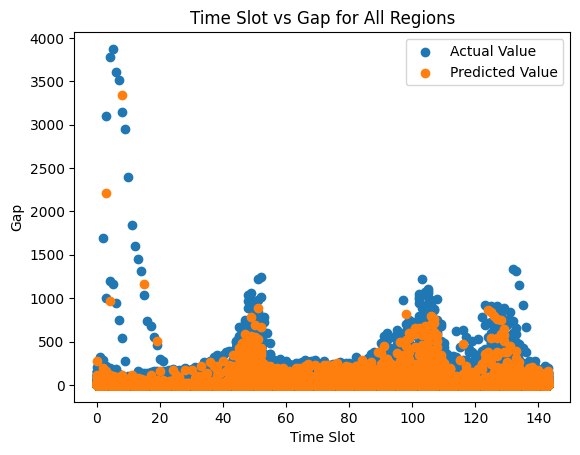

In [45]:
#Print graph
import matplotlib.pyplot as plt

plt.scatter(df['time_slot'], df['gap'], label = "Actual Value")
plt.scatter(X_test['time_slot'], predicted_gap, label="Predicted Value")
plt.xlabel('Time Slot')
plt.ylabel('Gap')
plt.title('Time Slot vs Gap for All Regions')
plt.legend()
plt.show()

## Specific Region


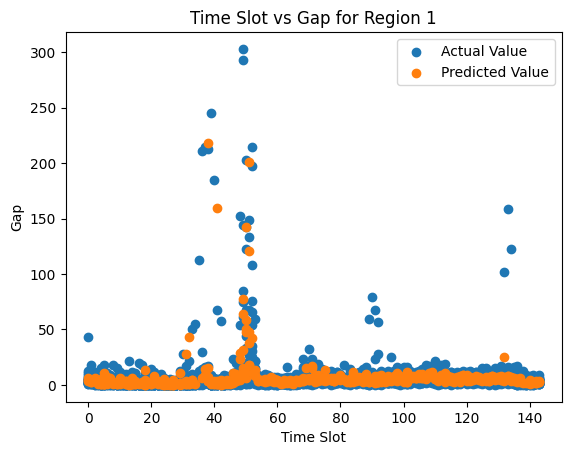

In [46]:
# Filter the data for region 1
selected_region = "1"

df_region1 = df[df["start_region_id"] == selected_region]

plt.scatter(df_region1["time_slot"], df_region1["gap"], label="Actual Value")
plt.scatter(
    X_test[X_test["start_region_id"] == selected_region]["time_slot"],
    predicted_gap[X_test["start_region_id"] == selected_region],
    label="Predicted Value"
)
plt.xlabel("Time Slot")
plt.ylabel("Gap")
plt.title(f"Time Slot vs Gap for Region {selected_region}")
plt.legend()
plt.show()

# Prediction For Next 14 Days

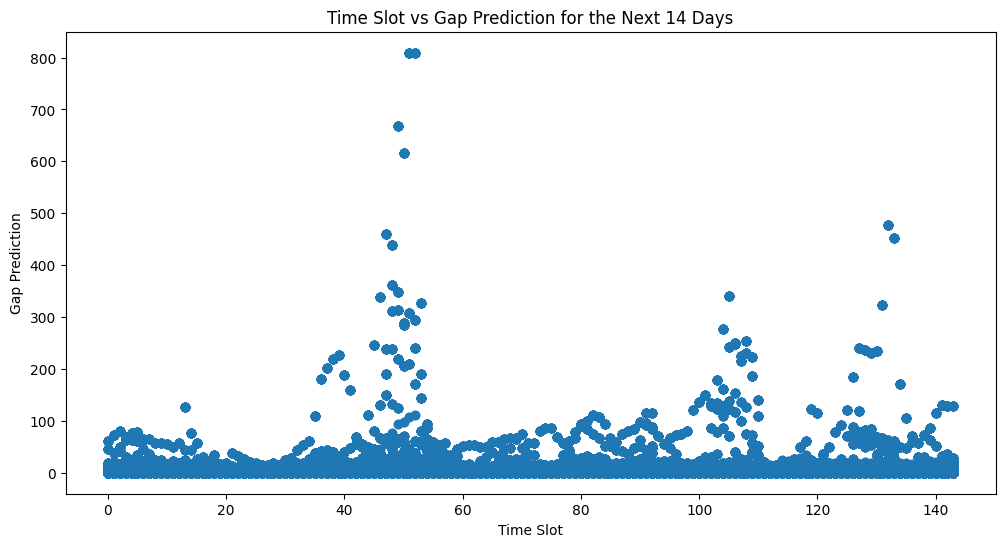

In [50]:
next_14_days = pd.DataFrame({
    'start_region_id': np.repeat(df['start_region_id'].unique(), 144 * 14),
    'time_slot': np.tile(np.arange(144), 14 * len(df['start_region_id'].unique())),
    'day': np.repeat(np.arange(14), 144 * len(df['start_region_id'].unique()))
})


# Use the trained model to predict the gap for the next 14 days
X_next_14_days = next_14_days[['start_region_id', 'time_slot', 'day']]
y_next_14_days = model.predict(X_next_14_days)

# Add the predicted gap to the new DataFrame
next_14_days['gap_prediction'] = y_next_14_days

# VISUALIZATION
# Visualize the prediction for the next 14 days
plt.figure(figsize=(12, 6))
plt.scatter(next_14_days['time_slot'], next_14_days['gap_prediction'])
plt.xlabel('Time Slot')
plt.ylabel('Gap Prediction')
plt.title('Time Slot vs Gap Prediction for the Next 14 Days')
plt.show()

In [51]:
next_14_days

,start_region_id,time_slot,day,gap_prediction
0,1,0,0,6.33
1,1,1,0,6.37
2,1,2,0,6.37
3,1,3,0,5.47
4,1,4,0,5.33
...,...,...,...,...
133051,9,139,13,0.04
133052,9,140,13,0.14
133053,9,141,13,1.28
133054,9,142,13,0.28
